In [1]:
%pylab inline
import uproot

Populating the interactive namespace from numpy and matplotlib


In [6]:
s500_dm1_file =  uproot.open("mc_392924.SlepSlep_direct_500p5_1p0_2L8.exactly2lep.root")
s100_dm50_file =  uproot.open("mc_392925.SlepSlep_direct_100p0_50p0_2L8.exactly2lep.root")
s200_dm100_file = uproot.open("mc_392936.SlepSlep_direct_200p0_100p0_2L8.exactly2lep.root")
sets = [s500_dm1_file, s100_dm50_file, s200_dm100_file]

## Functions

In [3]:
SMALL_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth = 3)
plt.rc('figure', figsize= (7, 5))

In [4]:
def make_fig(xTitle="xTitle",yTitle="yTitle"):
    fig = plt.figure()

    ax = plt.gca()
    ax.set_prop_cycle(color=['#002BFF','#A15FFF','#FF0061','#FF8913'])
    ax.set_xlabel(xTitle,labelpad=6)
    ax.set_ylabel(yTitle)
    ax.tick_params(direction='out', length=8, width=2)
    ax.yaxis.offsetText.set_fontsize(10)
    #ax.xaxis.labelpad = 15
    #ax.yaxis.labelpad = 15
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    return fig, ax

In [10]:
def mt2(file, mdm, indices = None):
    mets = file[b'mini;1'].array(b'met_et')
    mets_phi = file[b'mini;1'].array(b'met_phi')
    lep_pt = file[b'mini;1'].array(b'lep_pt')
    lep_eta = file[b'mini;1'].array(b'lep_eta')
    lep_phi = file[b'mini;1'].array(b'lep_phi')
    if indices:
        mets = np.take(mets, indices)
        mets_phi = np.take(mets_phi, indices)
        lep_pt = np.take(lep_pt, indices)
        lep_eta = np.take(lep_eta, indices)
        lep_phi = np.take(lep_phi, indices)

    lep_p = np.multiply(lep_pt, np.cosh(lep_eta))
    mpts = np.sqrt(mets**2 - mdm**2)
    lep_et = lep_pt/lep_p
    
    # split q in equal increments of magnitude and phi
    splittings_mag = []
    for mpt in mpts:
        splittings_mag.append(np.linspace(0, mpt, 10))
    s_phi = np.linspace(0, 2*pi, 10)
    
    mt2 = []
    for i, qs in enumerate(splittings_mag):
        #print(i)
        max_mtq = []
        for q in qs:
            eq = np.sqrt(q**2 + mdm**2)
            vec_mpt = np.array([[mpts[i]*np.cos(mets_phi[i]), mpts[i]*np.sin(mets_phi[i])]]*len(s_phi))
            vec_q = np.column_stack([q*np.cos(s_phi), q*np.sin(s_phi)])
            vec_minq = np.array(vec_mpt - vec_q)
            vec_lep1 = np.array([[lep_pt[i][0]*np.cos(lep_phi[i][0]), lep_pt[i][0]*np.sin(lep_phi[i][0])]]*len(s_phi))
            vec_lep2 = np.array([[lep_pt[i][1]*np.cos(lep_phi[i][1]), lep_pt[i][1]*np.sin(lep_phi[i][1])]]*len(s_phi))
            eqmin = np.sqrt(np.array([sum(x) for x in np.multiply(vec_minq, vec_minq)]) + mdm**2)
            
            p1qt = np.array([sum(x) for x in np.multiply(vec_q, vec_lep1)])
            p2mqt = np.array([sum(x) for x in np.multiply(vec_minq, vec_lep2)])
            
            mtalpha = np.sqrt(2*(lep_et[i][0]*eq - p1qt))
            mtbeta =  np.sqrt(2*(lep_et[i][1]*eqmin - p2mqt))
            #mtalpha = np.where(np.isnan(mtalpha), -1, mtalpha)
            #mtbeta = np.where(np.isnan(mtbeta), -1, mtbeta)
            
            max_mtq.append(np.where(mtalpha >= mtbeta, mtalpha, mtbeta))
        max_mtq = np.array(max_mtq)
        mask = (np.isnan(max_mtq))
        max_mtq[mask] = -1
        max_mtq[mask] = np.max(max_mtq)+1
        mt2.append(np.min(max_mtq))
    return np.array(mt2)

## MET distribution

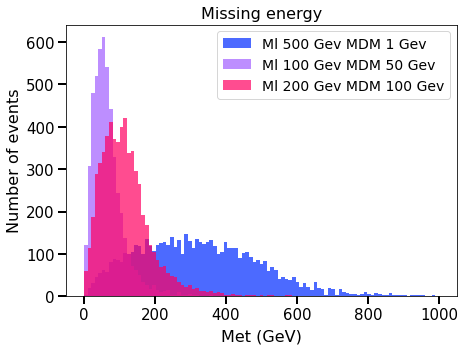

In [7]:
make_fig("Met (GeV)", "Number of events")
title("Missing energy")
nbins   = 100 # number of bins in histogram
xlow    = 0
xhigh   = 1000
bins    = np.linspace(xlow, xhigh, nbins)
for i in range(len(sets)):
    n, bins, patches = plt.hist(sets[i][b'mini;1'].array('met_et')/1e3, bins, alpha = 0.7)
legend(["Ml 500 Gev MDM 1 Gev", "Ml 100 Gev MDM 50 Gev", "Ml 200 Gev MDM 100 Gev"])

## MT2 Distribution for (500 GeV, 1GeV)

We build something called "stransverse mass". Recall regular transverse mass for a 1-> 2 decay:
\begin{align}
m_T = \sqrt{2 (E_{T1}E_{T2} - \mathbf{p_{T1}\cdot p_{T2}})}
\end{align}
or 
\begin{align}
m_T = \sqrt{2 (E_{T1}E_{T2} - |p_{T1}||p_{T2}|\cos(\Delta \phi)}
\end{align}
Where 
\begin{align}
E_T = E\frac{|p_T|}{|p|}
\end{align}
and
\begin{align}
m_T \leq m
\end{align}

Here, we have two $\tilde l-> l + DM$, where the $DM$ goes into $MET$. However, we don't know how the $MET$ is split up between the two unknown $DM$ particles, which means we have to split $\mathbf{p_{T}}^{miss}$ into all possible combinations $\mathbf{q_T}$ and $\mathbf{p_{T}}^{miss} - \mathbf{q_T}$. Then, we define the the $m_{T2}$ variable ("stransverse mass") as:
\begin{align}
m_{T2} = \text{min}_{\mathbf{q_T}}\bigg \{\text{max} \big[m_T(\mathbf{p_T^{\alpha}}, \mathbf{q_T}, MDM), m_T(\mathbf{p_T^{\beta}}, \mathbf{p_{T}}^{miss} - \mathbf{q_T}, MDM)]\big]\bigg\}
\end{align}

Where $\alpha$ and $\beta$ indicate the two respective $\tilde{l} -> l + DM$ decays we are looking at.

Note that we assume $|p_T| \approx |p|$.

$m_{T2}$ satisfies the inequality:
\begin{align}
m_{T2}^2 \leq m_{\tilde l}^2 - MDM^2
\end{align}

In [8]:
mt2_0 = mt2(sets[0], 1e3)

C:\Users\Wenjie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Wenjie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


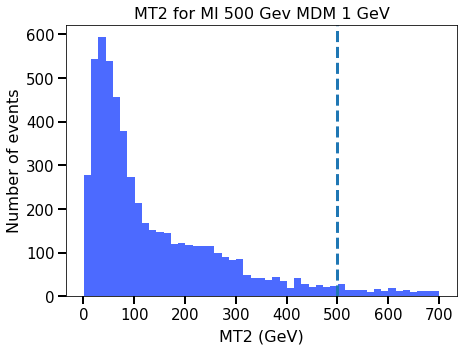

In [9]:
make_fig("MT2 (GeV)", "Number of events")
title("MT2 for Ml 500 Gev MDM 1 GeV")
nbins   = 50 # number of bins in histogram
xlow    = 1
xhigh   = 700
bins    = np.linspace(xlow, xhigh, nbins)
n, bins, patches = plt.hist(np.array(mt2_0)/1e3, bins, alpha = 0.7)
axvline(np.sqrt(500**2-1**2), linestyle = "--")